# This notebook evaluates our default route measurement results.

We currently use a fixed timestamp for Bush to get the same results every run!

Imports
Loading measurement results


1) How many AS are using DR overall? <br>
--> Done<br>
2) Split into tiers, how many use DR?<br>
--> Done<br>
3) Compare IPv4 and IPv6 - any deviations or are they in sync?<br>
-->Ripe roughly the same, NLNOG slightly lower for IPv6, Bush significantly lower for IPv6, especially tier3<br>
4) NLNog/RIPE Atlas comparison<br>
--> Equal ASes:  251, Unequal ASes:  22<br>
5) Direction of DR always to the same upstream ASs or different? Do some upstreams require DR more often?<br>
6) Do we observe multiple probes in one AS having different DRs?<br>
--> Yes! E.g. 3320 example. Add to paper.<br>
7) AS1 identification are faulty or correct? Interpretation of methodology wrong?<br>
--> Mixed also in Bush 2010.<br>
8) Compare methodology results.<br>
9) Do we get opposing results for ZMap and RIPE Atlas within the Bush measurements?<br>
10) How many ASs can we identify traversing multiple ASs, not only the first hop is different?<br>
11) Do we need to merge both resultsets and take the union as overall result, since if an identification was positive in one method a DR must be present?<br>
12) Which upstreams are most often? HitCount?<br>
13) Build CDF for threshold value to see where it converges.<br>
--> Done <br>
14) Look at FPs in more detail. Optometry paper mentioned DR-Mixed category. Where default == true and probe_hit != 0 print entry.<br>

In [1]:
#imports
import csv
import mariadb
import sys
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import numpy as np
import datetime
import json

In [2]:
#functions

#['asn_nr', 'asn_dr', 'asn_dr_to', 'tier']
#['39138', 'False', 'False', '2']
#['24785', 'False', 'False', '2']
#['16509', 'True', '2914,174,9286,4755,1221,1299,4134', '2']
def results_parser_hlavacek(input_file):
    input_dict = {}
    with open('hlavacek_results/' + input_file + '.csv', mode='r') as infile:
        next(infile) #skip header
        reader = csv.reader(infile)
        for line in reader:
            dr = False
            if line[1] != 'False': dr = True
                
            upstream = False
            if line[2] != 'False': upstream = [int(x) for x in line[2].split(',')]

            input_dict[int(line[0])]=[dr, upstream, int(line[3])]
    return input_dict

In [3]:
#Read measurement results
hlavacek_nlnog_1614379868 = results_parser_hlavacek("hlavacek_nlnog_1614379868")
hlavacek_nlnog_1614462534 = results_parser_hlavacek("hlavacek_nlnog_1614462534")
hlavacek_nlnog_1614464467 = results_parser_hlavacek("hlavacek_nlnog_1614464467")
hlavacek_nlnog_1614549248 = results_parser_hlavacek("hlavacek_nlnog_1614549248")
hlavacek_nlnog_1614550733 = results_parser_hlavacek("hlavacek_nlnog_1614550733")

hlavacek_ripe_29207513 = results_parser_hlavacek("hlavacek_ripe_29207513")
hlavacek_ripe_29207634 = results_parser_hlavacek("hlavacek_ripe_29207634")
hlavacek_ripe_29212422 = results_parser_hlavacek("hlavacek_ripe_29212422")
hlavacek_ripe_29212828 = results_parser_hlavacek("hlavacek_ripe_29212828")
hlavacek_ripe_29213238 = results_parser_hlavacek("hlavacek_ripe_29213238")

In [4]:
#Mysql connector to read results:
# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="asdrc",
        password="cQGTVKsmf2tVaVdDGeky4AvHMp9P6aJY",
        host="localhost",
        port=3306,
        database="asdrc"
    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

In [5]:
def fetch_from_db(ripe_ipv4, ripe_ipv6, nlnog_ipv4, nlnog_ipv6, db_query):
    #+----------------+------------+------+-----+---------+----------------+
    #| Field          | Type       | Null | Key | Default | Extra          |
    #+----------------+------------+------+-----+---------+----------------+
    #| id             | int(11)    | NO   | PRI | NULL    | auto_increment |
    #| asn            | int(11)    | NO   |     | NULL    |                |
    #| ip_version     | int(11)    | NO   |     | NULL    |                |
    #| default_route  | text       | NO   |     | NULL    |                |
    #| default_target | text       | NO   |     | NULL    |                |
    #| probe_provider | text       | NO   |     | NULL    |                |
    #| msm_id         | int(11)    | NO   |     | NULL    |                |
    #| count_probes   | int(11)    | NO   |     | NULL    |                |
    #| count_hits     | int(11)    | NO   |     | NULL    |                |
    #| timestamp      | int(11)    | NO   |     | NULL    |                |
    #| raw_traceroute | mediumtext | NO   |     | NULL    |                |
    #+----------------+------------+------+-----+---------+----------------+

    cur.execute(db_query)
    for result in cur:
        print(result)
        dr = False
        if result[3] != 'False': dr = True #We are going to overwrite this field later
                
        #render upstreams into array of ints, if present, otherwise False.
        upstream = False
        if result[4] != 'False': upstream = [int(x) for x in result[4].split(',')]

        #generate result dicts from DB infos
        if result[2] == 4 and result[5] == 'ripe':
            ripe_ipv4[result[1]] = [dr,upstream,result[6],result[7],result[8]]
        elif result[2] == 4 and result[5] == 'nlnog':
            nlnog_ipv4[result[1]] = [dr,upstream,result[6],result[7],result[8]]
        elif result[2] == 6 and result[5] == 'ripe':
            ripe_ipv6[result[1]] = [dr,upstream,result[6],result[7],result[8]]
        elif result[2] == 6 and result[5] == 'nlnog':
            nlnog_ipv6[result[1]] = [dr,upstream,result[6],result[7],result[8]]
            
                #generate result dicts from DB infos
#        if result[2] == 4 and result[5] == 'ripe':
#            ripe_ipv4[result[1]] = [dr,upstream,result[6],result[8],result[7]]
#        elif result[2] == 4 and result[5] == 'nlnog':
#            nlnog_ipv4[result[1]] = [dr,upstream,result[6],result[8],result[7]]
#        elif result[2] == 6 and result[5] == 'ripe':
#            ripe_ipv6[result[1]] = [dr,upstream,result[6],result[8],result[7]]
#        elif result[2] == 6 and result[5] == 'nlnog':
#            nlnog_ipv6[result[1]] = [dr,upstream,result[6],result[8],result[7]]

    return ripe_ipv4, ripe_ipv6, nlnog_ipv4, nlnog_ipv6 

def fetch_from_db_bush(ipv4, ipv6, db_query):
#    +-----------------+------------+------+-----+---------+----------------+
#    | Field           | Type       | Null | Key | Default | Extra          |
#    +-----------------+------------+------+-----+---------+----------------+
#    | id              | int(11)    | NO   | PRI | NULL    | auto_increment |
#    | asn             | int(11)    | NO   |     | NULL    |                |
#    | ip_version      | int(11)    | NO   |     | NULL    |                |
#    | default_route   | text       | NO   |     | NULL    |                |
#    | default_target  | text       | NO   |     | NULL    |                |
#    | timestamp       | int(11)    | NO   |     | NULL    |                |
#    | lookahead_dead  | text       | NO   |     | NULL    |                |
#    | lookahead_ripe  | mediumtext | YES  |     | NULL    |                |
#    | validation_ripe | mediumtext | YES  |     | NULL    |                |
#    +-----------------+------------+------+-----+---------+----------------+


    cur.execute(db_query)
    for result in cur:
        if line[6] != '0' and int(line[5]) <= 1622457791:
            dr = False
            if result[3] != '0': dr = True

            #render upstreams into array of ints, if present, otherwise False.
            upstream = False
            if result[4] != '0': upstream = [int(x) for x in result[4].split(',')]

            if result[5] != '0': timestamp = result[5]

            #if result[1] in ipv4:
            #    print('Found: ', result[1])
            #generate result dicts from DB infos

            #Fill 0,0 for probes_total and probes_hit to use same methods later for eval
            if result[2] == 4:
                ipv4[result[1]] = [dr,upstream,timestamp,0,0]
            if result[2] == 6:
                ipv6[result[1]] = [dr,upstream,timestamp,0,0]
        else:
            print(result)

    return ipv4, ipv6

def get_timestring(timestamp):
    return datetime.datetime.strftime(datetime.datetime.fromtimestamp(timestamp),"%a %b %d %Y %H:%M:%S (GMT+0100)")

In [6]:
#Render DefaultRoute inferences for Hlavacek:

def dr_identification(day1, dr_threshold):
    for result in day1: #its 4 dicts
        for asn in result:
            # [dr,upstream,result[6],result[7],result[8]]
            probes_used = result[asn][3]
            probes_positive = result[asn][4]
            if probes_used != 0:
                if (1 / probes_used * probes_positive) >= dr_threshold:
                    result[asn][0] = True
                else:
                    result[asn][0] = False
                    
def update_results_with_tiers(day, tier_classification):
    for result in day: #its 4 dicts
        update_single_result_with_tiers(result, tier_classification)

def update_single_result_with_tiers(result, tier_classification):
    for asn in result:
        # [dr,upstream,result[6],result[7],result[8]]
        if asn in tier_classification:
            result[asn].append(tier_classification[asn])
        else:
            result[asn].append(3) #if ASes cannot be found we assign tier3, very rare case
        
#def get_dr_ratio(result, dr_threshold):
#    #[False, False, 29229398, 7, 0]
#    counter = 0
#    for asn in result:
#        probes_used = result[asn][3]
#        probes_positive = result[asn][4]
#        if probes_used != 0:
#            if (1 / probes_used * probes_positive) >= dr_threshold:
#                print(result[asn])
#                counter += 1 #only increase counter if threshold was exceeded
#    return counter

def get_dr_ratio_tier(resultset, tier):
    #dr, upstream, timestamp, total, hit, tier
    #[False, False, 29195712, 1, 0, 2]
    tier_total = 0
    tier_dr = 0
    for asn in resultset:
        if resultset[asn][5] == tier:
            tier_total += 1
            if resultset[asn][0] == True:
                tier_dr += 1
    #print(len(resultset),counter)
    if tier_total != 0:
        tier_ratio = round(100/tier_total*tier_dr, 2)
    else:
        tier_ratio = 0
    return tier_total, tier_dr, tier_ratio

def get_dr_ratio(resultset):
    counter = 0
    for asn in resultset:
        if resultset[asn][0] == True:
            counter += 1
    #print(len(resultset),counter)
    return counter



def get_ratio_string(resultset):
    if len(resultset) != 0:
        return str(len(resultset)) + ', DRs: ' + str(get_dr_ratio(resultset)) + ', Ratio: ' + str(round(100/len(resultset)*get_dr_ratio(resultset),2)) + ', Tier1, Tier1-DR, Tier1-Ratio: ' + str(get_dr_ratio_tier(resultset, 1))  + ', Tier2, Tier2-DR, Tier2-Ratio: ' + str(get_dr_ratio_tier(resultset, 2))  + ', Tier3, Tier3-DR, Tier3-Ratio: ' + str(get_dr_ratio_tier(resultset, 3))
    else:
        return str(len(resultset)) + ', DRs: ' + str(get_dr_ratio(resultset)) + ', Ratio: 0'

def get_ratio_data(resultset):
    if len(resultset) != 0:
        return [len(resultset), get_dr_ratio(resultset), (round(100/len(resultset)*get_dr_ratio(resultset),2))]
    else:
        return [len(resultset), get_dr_ratio(resultset), 0]
    
def merge_Atlas_NLNOG(atlas, nlnog):
    result = {}
    for asn in atlas.keys():
        result[asn] = atlas[asn] #Copy whole dict
    for asn in (nlnog.keys() - (atlas.keys() & nlnog.keys())):
        result[asn] = nlnog[asn] #Copy missing elements
    return result

In [7]:
#print number of ASNs contained in CAIDA and Problink files:
def print_unique_asns(file):
    unique_asns = set()
    with open(file) as fp:
        lines = fp.readlines()
        for line in lines:
            provider = int(line.split('|')[0])
            customer = int(line.split('|')[1])
            rel = int(line.split('|')[2])
            unique_asns.add(provider)
            unique_asns.add(customer)
    return len(unique_asns)

print('Unique # of ASNs per AS-rel dataset: ')
print('CAIDA: ', print_unique_asns("data/caida_20210501.txt"))
print('Problink: ', print_unique_asns("data/problink_20210401.txt"))

Unique # of ASNs per AS-rel dataset: 
CAIDA:  72004
Problink:  44695


In [8]:
def print_tierdata(tier_classification):
    tier1 = 0
    tier2 = 0 
    tier3 = 0
    for asn in tier_classification:
        if tier_classification[asn] == 1: tier1+= 1
        elif tier_classification[asn] == 2: tier2+= 1
        elif tier_classification[asn] == 3: tier3+= 1
    total = tier1 + tier2 + tier3
    print('Tier 1: ' + str(tier1) + ' (' + str(round(100 / total * tier1,2)) + '); Tier 2: ' + str(tier2) + ' (' + str(round(100 / total * tier2,2)) + '); Tier 3: ' + str(tier3) + ' (' + str(round(100 / total * tier3,2)) + ')') 

tier_classification = {}
unique_asns = set()
input_clique = {174,209,286,701,1239,1299,2828,2914,3257,3320,3356,3491,5511,6453,6461,6762,6830,7018,12956} #require no transit to obtain global connectivity, from CAIDA

for asn in input_clique:
    tier_classification[asn] = 1
    
print('Fixed number of tier 1 ASes from input clique: ', len(input_clique))
print()

#Data Format:
#<provider-as>|<customer-as>|-1
#<peer-as>|<peer-as>|0
#<sibling-as>|<sibling-as>|1 

with open("data/caida_20210501.txt") as fp:
#with open("data/problink_20210401.txt") as fp:
    lines = fp.readlines()
         
    #add all customer ASes as tier3
    for line in lines:
        provider = int(line.split('|')[0])
        customer = int(line.split('|')[1])
        rel = int(line.split('|')[2])
        if rel == -1 and customer not in tier_classification:
            tier_classification[customer] = 3

    print('Add all customer ASes as tier3')
    print_tierdata(tier_classification) 
    print()
    
    #make all providers tier2, except the tier1s
    for line in lines:
        provider = int(line.split('|')[0])
        customer = int(line.split('|')[1])
        rel = int(line.split('|')[2])
        if rel == -1 and provider not in input_clique:
            tier_classification[provider] = 2

    print('Make all providers tier2, except the tier1s')
    print_tierdata(tier_classification) 
    print()
         
    #add both ASes to tier2 if peering relationship exists
    for line in lines:
        provider = int(line.split('|')[0])
        customer = int(line.split('|')[1])
        rel = int(line.split('|')[2])
        if rel == 0 and provider not in tier_classification:
            tier_classification[provider] = 2
            if tier_classification[customer] == 3:
                tier_classification[customer] = 2
        elif rel == 0 and customer not in tier_classification:
            tier_classification[customer] = 2
            if tier_classification[provider] == 3:
                tier_classification[provider] = 2
                
    print('Add both ASes to tier2 if peering relationship exists')
    print_tierdata(tier_classification)
    print()    
    
    #show missing asns
    for line in lines:
        provider = int(line.split('|')[0])
        customer = int(line.split('|')[1])
        rel = int(line.split('|')[2])
        if provider not in tier_classification or customer not in tier_classification:
            print(provider, customer, rel)

print('Number of classified ASes: ', len(tier_classification))


Fixed number of tier 1 ASes from input clique:  19

Add all customer ASes as tier3
Tier 1: 19 (0.03); Tier 2: 0 (0.0); Tier 3: 71598 (99.97)

Make all providers tier2, except the tier1s
Tier 1: 19 (0.03); Tier 2: 10981 (15.31); Tier 3: 60716 (84.66)

Add both ASes to tier2 if peering relationship exists
Tier 1: 19 (0.03); Tier 2: 11325 (15.73); Tier 3: 60660 (84.25)

Number of classified ASes:  72004


In [9]:
#db_table = 'hlavacek'
db_table = 'hlavacek_relaunch'

In [10]:
#Get Hlavacek measurement days:

#Tue Feb 23 2021 00:00:00 GMT+0100: 1614034800
#Tue Feb 23 2021 23:59:59 GMT+0100: 1614121199

measurements = [#[1614081600,1614167999],
                #[1614203720,1614254399], #-old eval
                #[1614254400,1614340799],
                #[1614340800,1614427199],
                #[1614427200,1614513599],
                #[1614513600,1614599999],
                #[1614600000,1614686399]] #-old eval
                #[1614686400,1614772799],
                #[1620561600,1620647999],
                #[1620648000,1620734399],
                #[1620734400,1620820799],
                #[1620820800,1620907199],
                #[1620907200,1620993599],
                #[1620993600,1621079999],
                #[1621080000,1621166399],
                #[1621166400,1621252799],
                #[1621252800,1621339199],
                #[1621339200,1621425599],
                #[1621425600,1621511999],
                #[1621512000,1621598399],
                #[1621598400,1621684799],
                #[1621684800,1621771199],
                #[1621771200,1621857599],
                #[1621857600,1621943999],
                #[1621944000,1622030399],                
                [1624449600,1624535999],
                [1624536000,1624622399],
                [1624622400,1624708799],
                [1624708800,1624795199],
                [1624795200,1624881599],
                [1624881600,1624967999]]

for measurement in measurements:
    cur.execute("SELECT COUNT(*) FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurement[0]) + " and " + str(measurement[1]))
    for result in cur: print(get_timestring(measurement[0]) + ' to ' + get_timestring(measurement[1]), result)
    
print()



Wed Jun 23 2021 14:00:00 (GMT+0100) to Thu Jun 24 2021 13:59:59 (GMT+0100) (6869,)
Thu Jun 24 2021 14:00:00 (GMT+0100) to Fri Jun 25 2021 13:59:59 (GMT+0100) (6854,)
Fri Jun 25 2021 14:00:00 (GMT+0100) to Sat Jun 26 2021 13:59:59 (GMT+0100) (6863,)
Sat Jun 26 2021 14:00:00 (GMT+0100) to Sun Jun 27 2021 13:59:59 (GMT+0100) (6881,)
Sun Jun 27 2021 14:00:00 (GMT+0100) to Mon Jun 28 2021 13:59:59 (GMT+0100) (6886,)
Mon Jun 28 2021 14:00:00 (GMT+0100) to Tue Jun 29 2021 13:59:59 (GMT+0100) (6871,)



In [11]:
# Set threshold for DR == True:
dr_threshold = 0.55 # %of all probes need to have a DR

In [12]:
#Transform single day measurement results into dicts for eval later on

#########
# Day 1 #
#########

results_hlavacek_day1_ripe_ipv4 = {}
results_hlavacek_day1_ripe_ipv6 = {}
results_hlavacek_day1_nlnog_ipv4 = {}
results_hlavacek_day1_nlnog_ipv6 = {}

db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[1][0]) + " and " + str(measurements[1][1])
#db_query = "SELECT * FROM hlavacek WHERE timestamp BETWEEN 1614199800 and 1614207599"
fetch_from_db(results_hlavacek_day1_ripe_ipv4, results_hlavacek_day1_ripe_ipv6, results_hlavacek_day1_nlnog_ipv4, results_hlavacek_day1_nlnog_ipv6, db_query)

day1 = [results_hlavacek_day1_ripe_ipv4, results_hlavacek_day1_ripe_ipv6, results_hlavacek_day1_nlnog_ipv4, results_hlavacek_day1_nlnog_ipv6]


#########
# Day 2 #
#########

results_hlavacek_day2_ripe_ipv4 = {}
results_hlavacek_day2_ripe_ipv6 = {}
results_hlavacek_day2_nlnog_ipv4 = {}
results_hlavacek_day2_nlnog_ipv6 = {}

db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[2][0]) + " and " + str(measurements[2][1])
fetch_from_db(results_hlavacek_day2_ripe_ipv4, results_hlavacek_day2_ripe_ipv6, results_hlavacek_day2_nlnog_ipv4, results_hlavacek_day2_nlnog_ipv6, db_query)

day2 = [results_hlavacek_day2_ripe_ipv4, results_hlavacek_day2_ripe_ipv6, results_hlavacek_day2_nlnog_ipv4, results_hlavacek_day2_nlnog_ipv6]


#########
# Day 3 #
#########

results_hlavacek_day3_ripe_ipv4 = {}
results_hlavacek_day3_ripe_ipv6 = {}
results_hlavacek_day3_nlnog_ipv4 = {}
results_hlavacek_day3_nlnog_ipv6 = {}

db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[3][0]) + " and " + str(measurements[3][1])
#db_query = "SELECT * FROM hlavacek WHERE timestamp BETWEEN 1614294000 and 1614380399"
fetch_from_db(results_hlavacek_day3_ripe_ipv4, results_hlavacek_day3_ripe_ipv6, results_hlavacek_day3_nlnog_ipv4, results_hlavacek_day3_nlnog_ipv6, db_query)
  
day3 = [results_hlavacek_day3_ripe_ipv4, results_hlavacek_day3_ripe_ipv6, results_hlavacek_day3_nlnog_ipv4, results_hlavacek_day3_nlnog_ipv6]


#########
# Day 4 #
#########

results_hlavacek_day4_ripe_ipv4 = {}
results_hlavacek_day4_ripe_ipv6 = {}
results_hlavacek_day4_nlnog_ipv4 = {}
results_hlavacek_day4_nlnog_ipv6 = {}

db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[4][0]) + " and " + str(measurements[4][1])
fetch_from_db(results_hlavacek_day4_ripe_ipv4, results_hlavacek_day4_ripe_ipv6, results_hlavacek_day4_nlnog_ipv4, results_hlavacek_day4_nlnog_ipv6, db_query)

day4 = [results_hlavacek_day4_ripe_ipv4, results_hlavacek_day4_ripe_ipv6, results_hlavacek_day4_nlnog_ipv4, results_hlavacek_day4_nlnog_ipv6]

#########
# Day 5 #
#########

results_hlavacek_day5_ripe_ipv4 = {}
results_hlavacek_day5_ripe_ipv6 = {}
results_hlavacek_day5_nlnog_ipv4 = {}
results_hlavacek_day5_nlnog_ipv6 = {}

db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[5][0]) + " and " + str(measurements[5][1])
fetch_from_db(results_hlavacek_day5_ripe_ipv4, results_hlavacek_day5_ripe_ipv6, results_hlavacek_day5_nlnog_ipv4, results_hlavacek_day5_nlnog_ipv6, db_query)

day5 = [results_hlavacek_day5_ripe_ipv4, results_hlavacek_day5_ripe_ipv6, results_hlavacek_day5_nlnog_ipv4, results_hlavacek_day5_nlnog_ipv6]


#########
# Day 6 #
#########

#results_hlavacek_day6_ripe_ipv4 = {}
#results_hlavacek_day6_ripe_ipv6 = {}
#results_hlavacek_day6_nlnog_ipv4 = {}
#results_hlavacek_day6_nlnog_ipv6 = {}
#
#db_query = "SELECT * FROM " + db_table + " WHERE timestamp BETWEEN " + str(measurements[6][0]) + " and " + str(measurements[6][1])
#fetch_from_db(results_hlavacek_day6_ripe_ipv4, results_hlavacek_day6_ripe_ipv6, results_hlavacek_day6_nlnog_ipv4, results_hlavacek_day6_nlnog_ipv6, db_query)
#
#day6 = [results_hlavacek_day6_ripe_ipv4, results_hlavacek_day6_ripe_ipv6, results_hlavacek_day6_nlnog_ipv4, results_hlavacek_day6_nlnog_ipv6]

#########
# Day N #
#########
#
#results_hlavacek_dayN_ripe_ipv4 = {}
#results_hlavacek_dayN_ripe_ipv6 = {}
#results_hlavacek_dayN_nlnog_ipv4 = {}
#results_hlavacek_dayN_nlnog_ipv6 = {}####
#
#db_query = "SELECT * FROM hlavacek WHERE timestamp BETWEEN " + str(measurements[15][0]) + " and " + str(measurements[15][1])
#fetch_from_db(results_hlavacek_dayN_ripe_ipv4, results_hlavacek_dayN_ripe_ipv6, results_hlavacek_dayN_nlnog_ipv4, results_hlavacek_dayN_nlnog_ipv6, db_query)
#
#dayN = [results_hlavacek_dayN_ripe_ipv4, results_hlavacek_dayN_ripe_ipv6, results_hlavacek_dayN_nlnog_ipv4, results_hlavacek_dayN_nlnog_ipv6]
#dr_identification(dayN, dr_threshold)


#print()
#print('DayN:') 
#print('DayN, RIPE, IPv4: ', len(results_hlavacek_dayN_ripe_ipv4))
#print('DayN, NLNOG, IPv4: ', len(results_hlavacek_dayN_nlnog_ipv4))
#print('DayN, RIPE, IPv6: ', len(results_hlavacek_dayN_ripe_ipv6))
#print('DayN, NLNOG, IPv6: ', len(results_hlavacek_dayN_nlnog_ipv6))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(94234, 63311, 6, 'False', 'False', 'nlnog', 1624561359, 1, 0, 1624561359, "{'20c01.ring.nlnog.net': {'timestamp': '1624562240', 'fw': '?', 'mver': '?', 'lts': '?', 'endtime': 1624562243, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '?', 'proto': 'ICMP', 'af': 6, 'size': '?', 'paris_id': '?', 'result': [{'hop': 1, 'result': [{'from': '2607:fae0:f202:44c::3', 'rtt': '1.260'}, {'from': '2607:fae0:f202:44c::3', 'rtt': '1.103'}, {'from': '2607:fae0:f202:44c::3', 'rtt': '1.143'}]}], 'msm_id': 1624561359, 'prb_id': '20c01.ring.nlnog.net', 'msm_name': '?', 'from': '20c01.ring.nlnog.net', 'type': 'traceroute', 'group_id': '?', 'stored_timestamp': '1624562243'}}")
(94235, 205668, 6, 'False', 'False', 'nlnog', 1624561359, 1, 0, 1624561359, "{'greenmini01.ring.nlnog.net': {'timestamp': '1624562239', 'fw': '?', 'mver': '?', 'lts': '?', 'endtime': 1624562706, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '?', 'proto': 'ICMP', 'af': 6, 'size':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(459131, 20926, 4, 'True', '174', 'ripe', 31003366, 3, 1, 1624641602, "{1252: {'fw': 4790, 'lts': 50, 'endtime': 1624641694, 'dst_name': '184.164.232.1', 'dst_addr': '184.164.232.1', 'src_addr': '10.40.72.101', 'proto': 'ICMP', 'af': 4, 'size': 48, 'paris_id': 0, 'result': [{'hop': 1, 'result': [{'from': '10.40.72.254', 'ttl': 255, 'size': 28, 'rtt': 7.641}, {'from': '10.40.72.254', 'ttl': 255, 'size': 28, 'rtt': 4.117}, {'from': '10.40.72.254', 'ttl': 255, 'size': 28, 'rtt': 1.846}]}, {'hop': 2, 'result': [{'from': '10.40.255.17', 'ttl': 254, 'size': 28, 'rtt': 2.085}, {'from': '10.40.255.17', 'ttl': 254, 'size': 28, 'rtt': 3.233}, {'from': '10.40.255.17', 'ttl': 254, 'size': 28, 'rtt': 2.537}]}, {'hop': 3, 'result': [{'from': '10.40.255.22', 'ttl': 253, 'size': 28, 'rtt': 3.226}, {'from': '10.40.255.22', 'ttl': 253, 'size': 28, 'rtt': 1.617}, {'from': '10.40.255.22', 'ttl': 253, 'size': 28, 'rtt': 1.272}]}, {'hop': 4, 'result': [{'from': '80.74.64.201', 'ttl': 252, 'size': 28, 'rtt'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(462272, 20911, 4, 'True', '57344', 'ripe', 31003714, 1, 1, 1624643269, "{1001226: {'fw': 5020, 'mver': '2.2.1', 'lts': 57, 'endtime': 1624643402, 'dst_name': '184.164.232.1', 'dst_addr': '184.164.232.1', 'src_addr': '192.168.16.69', 'proto': 'ICMP', 'af': 4, 'size': 48, 'paris_id': 0, 'result': [{'hop': 1, 'result': [{'from': '192.168.16.1', 'ttl': 64, 'size': 28, 'rtt': 12.797}, {'from': '192.168.16.1', 'ttl': 64, 'size': 28, 'rtt': 10.578}, {'from': '192.168.16.1', 'ttl': 64, 'size': 28, 'rtt': 11.997}]}, {'hop': 2, 'result': [{'from': '172.17.17.1', 'ttl': 63, 'size': 76, 'rtt': 12.101}, {'from': '172.17.17.1', 'ttl': 63, 'size': 76, 'rtt': 11.048}, {'from': '172.17.17.1', 'ttl': 63, 'size': 76, 'rtt': 1.888}]}, {'hop': 3, 'result': [{'from': '172.16.3.1', 'ttl': 62, 'size': 76, 'rtt': 2.297}, {'from': '172.16.3.1', 'ttl': 62, 'size': 76, 'rtt': 2.284}, {'from': '172.16.3.1', 'ttl': 62, 'size': 76, 'rtt': 2.34}]}, {'hop': 4, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(464645, 7712, 6, 'True', '55329', 'ripe', 31003953, 1, 1, 1624644690, "{6206: {'fw': 5020, 'mver': '2.2.1', 'lts': 14, 'endtime': 1624644814, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '2405:aa00:1::54', 'proto': 'ICMP', 'af': 6, 'size': 48, 'paris_id': 0, 'result': [{'hop': 1, 'result': [{'from': '2405:aa00:1::1', 'ttl': 64, 'rtt': 11.245, 'size': 96}, {'from': '2405:aa00:1::1', 'ttl': 64, 'rtt': 11.006, 'size': 96}, {'from': '2405:aa00:1::1', 'ttl': 64, 'rtt': 10.708, 'size': 96}]}, {'hop': 2, 'result': [{'from': '2405:aa00:0:106::2', 'ttl': 63, 'rtt': 2.98, 'size': 96}, {'from': '2405:aa00:0:106::2', 'ttl': 63, 'rtt': 1.446, 'size': 96}, {'from': '2405:aa00:0:106::2', 'ttl': 63, 'rtt': 0.748, 'size': 96}]}, {'hop': 3, 'result': [{'from': '2405:aa00:aa01:518::1', 'ttl': 62, 'rtt': 1.8, 'size': 96, 'itos': 128}, {'from': '2405:aa00:aa01:518::1', 'ttl': 62, 'rtt': 7.492, 'size': 96, 'itos': 128}, {'from': '2405:aa00:aa01:518::1', 'ttl': 62, 'rtt': 1.315

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(472485, 204151, 6, 'False', 'False', 'nlnog', 1624734191, 1, 0, 1624734191, "{'kviknet01.ring.nlnog.net': {'timestamp': '1624735057', 'fw': '?', 'mver': '?', 'lts': '?', 'endtime': 1624735538, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '?', 'proto': 'ICMP', 'af': 6, 'size': '?', 'paris_id': '?', 'result': [{'hop': 1, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 2, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 3, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 4, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 5, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 6, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 7, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 8, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 9, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 10, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 11, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(473984, 200037, 4, 'True', '50304', 'ripe', 31036952, 1, 1, 1624814404, "{24593: {'fw': 5020, 'mver': '2.2.1', 'lts': 6, 'endtime': 1624814498, 'dst_name': '184.164.232.1', 'dst_addr': '184.164.232.1', 'src_addr': '172.16.0.146', 'proto': 'ICMP', 'af': 4, 'size': 48, 'paris_id': 0, 'result': [{'hop': 1, 'result': [{'from': '172.16.0.1', 'ttl': 255, 'size': 76, 'rtt': 4.834}, {'from': '172.16.0.1', 'ttl': 255, 'size': 76, 'rtt': 0.405}, {'from': '172.16.0.1', 'ttl': 255, 'size': 76, 'rtt': 0.343}]}, {'hop': 2, 'result': [{'from': '31.169.48.61', 'ttl': 254, 'size': 28, 'rtt': 18.275}, {'from': '31.169.48.61', 'ttl': 254, 'size': 28, 'rtt': 1.054}, {'from': '31.169.48.61', 'ttl': 254, 'size': 28, 'rtt': 0.825}]}, {'hop': 3, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 4, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 5, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 6, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 7, 'result': [{'x': '*'}, {'x

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(479369, 8455, 6, 'False', 'False', 'nlnog', 1624820892, 1, 0, 1624820892, "{'atom01.ring.nlnog.net': {'timestamp': '1624821757', 'fw': '?', 'mver': '?', 'lts': '?', 'endtime': 1624822237, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '?', 'proto': 'ICMP', 'af': 6, 'size': '?', 'paris_id': '?', 'result': [{'hop': 1, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 2, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 3, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 4, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 5, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 6, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 7, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 8, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 9, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 10, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 11, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'h

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(497403, 19969, 6, 'False', 'False', 'ripe', 31051290, 1, 0, 1624903913, "{6884: {'fw': 5020, 'mver': '2.2.1', 'lts': 45, 'endtime': 1624904002, 'dst_name': '2804:269c:30::1', 'dst_addr': '2804:269c:30::1', 'src_addr': '2604:5800:a::3', 'proto': 'ICMP', 'af': 6, 'size': 48, 'paris_id': 0, 'result': [{'hop': 1, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 2, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 3, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 4, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 5, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}, {'hop': 255, 'result': [{'x': '*'}, {'x': '*'}, {'x': '*'}]}], 'msm_id': 31051290, 'prb_id': 6884, 'timestamp': 1624903930, 'msm_name': 'Traceroute', 'from': '2604:5800:a::3', 'type': 'traceroute', 'group_id': 31051290, 'stored_timestamp': 1624904015}}")
(497404, 395152, 6, 'False', 'False', 'ripe', 31051290, 1, 0, 1624903913, "{6890: {'fw': 5020, 'mver': '2.2.1', 'lts': 55, 'endtime': 162490395

In [13]:
#Update all dicts with tier information about ASNs
update_results_with_tiers(day1, tier_classification)
update_results_with_tiers(day2, tier_classification)
update_results_with_tiers(day3, tier_classification)
update_results_with_tiers(day4, tier_classification)
update_results_with_tiers(day5, tier_classification)

In [14]:
#results_hlavacek_day1_ripe_ipv4

dr_identification(day1, dr_threshold)

results_hlavacek_day1_ripe_ipv4

{206238: [False, False, 30987663, 7, 0, 3],
 1221: [False, False, 30987663, 1, 0, 2],
 3265: [False, False, 30987663, 21, 0, 2],
 5089: [False, False, 30987663, 46, 0, 2],
 7922: [False, [33083, 21928], 30987663, 136, 2, 2],
 33915: [False, [6830, 12315], 30987663, 30, 2, 2],
 5410: [False, False, 30987663, 18, 0, 2],
 7545: [False, [9942], 30987663, 15, 1, 2],
 35266: [True, [2914], 30987663, 1, 1, 2],
 204786: [False, False, 30987575, 1, 0, 2],
 9269: [False, False, 30987663, 2, 0, 2],
 12496: [False, False, 30987663, 4, 0, 2],
 13246: [False, False, 30987575, 1, 0, 3],
 39180: [False, False, 30987575, 2, 0, 2],
 12389: [False, [28812], 30987663, 28, 1, 2],
 12676: [False, False, 30987575, 2, 0, 2],
 15798: [True, [8501], 30987575, 1, 1, 2],
 34594: [False, False, 30987575, 2, 0, 2],
 12963: [False, False, 30987575, 3, 0, 2],
 24482: [False, [6453], 30987575, 2, 1, 2],
 57670: [False, [48964], 30987575, 2, 1, 3],
 134773: [False, [4538, 4134], 30987663, 4, 2, 3],
 2516: [False, False

In [15]:
print('ORIGINAL VALUES BEFORE RECALCULATION WITH THRESHOLD (FPs are still in here)')

print()
print('Day1:') 
print('Day1, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv4))
print('Day1, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv4))
print('Day1, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv6))
print('Day1, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv6))

print()

print('Day2, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day2_ripe_ipv4))
print('Day2, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day2_nlnog_ipv4))
print('Day2, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day2_ripe_ipv6))
print('Day2, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day2_nlnog_ipv6))

print()

print('Day3, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day3_ripe_ipv4))
print('Day3, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day3_nlnog_ipv4))
print('Day3, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day3_ripe_ipv6))
print('Day3, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day3_nlnog_ipv6))

print()

print('Day4, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day4_ripe_ipv4))
print('Day4, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day4_nlnog_ipv4))
print('Day4, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day4_ripe_ipv6))
print('Day4, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day4_nlnog_ipv6))

print()

print('Day5, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day5_ripe_ipv4))
print('Day5, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day5_nlnog_ipv4))
print('Day5, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day5_ripe_ipv6))
print('Day5, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day5_nlnog_ipv6))

#print()
#
#print('Day6, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day6_ripe_ipv4))
#print('Day6, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day6_nlnog_ipv4))
#print('Day6, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day6_ripe_ipv6))
#print('Day6, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day6_nlnog_ipv6))

#print('DayN, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_dayN_ripe_ipv4))
#print('DayN, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_dayN_nlnog_ipv4))
#print('DayN, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_dayN_ripe_ipv6))
#print('DayN, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_dayN_nlnog_ipv6))

ORIGINAL VALUES BEFORE RECALCULATION WITH THRESHOLD (FPs are still in here)

Day1:
Day1, RIPE, IPv4: 3607, DRs: 1128, Ratio: 31.27, Tier1, Tier1-DR, Tier1-Ratio: (12, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (1904, 438, 23.0), Tier3, Tier3-DR, Tier3-Ratio: (1691, 690, 40.8)
Day1, NLNOG, IPv4: 467, DRs: 114, Ratio: 24.41, Tier1, Tier1-DR, Tier1-Ratio: (3, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (308, 52, 16.88), Tier3, Tier3-DR, Tier3-Ratio: (156, 62, 39.74)
Day1, RIPE, IPv6: 1657, DRs: 532, Ratio: 32.11, Tier1, Tier1-DR, Tier1-Ratio: (9, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (974, 259, 26.59), Tier3, Tier3-DR, Tier3-Ratio: (674, 273, 40.5)
Day1, NLNOG, IPv6: 467, DRs: 105, Ratio: 22.48, Tier1, Tier1-DR, Tier1-Ratio: (3, 1, 33.33), Tier2, Tier2-DR, Tier2-Ratio: (308, 49, 15.91), Tier3, Tier3-DR, Tier3-Ratio: (156, 55, 35.26)

Day2, RIPE, IPv4: 3609, DRs: 1400, Ratio: 38.79, Tier1, Tier1-DR, Tier1-Ratio: (12, 5, 41.67), Tier2, Tier2-DR, Tier2-Ratio: (1903, 609, 32.0), Tier3, Tier3-DR, Tier

In [16]:
#RECALCULATING DefaultRoutes according to threshold
dr_identification(day1, dr_threshold)
dr_identification(day2, dr_threshold)
dr_identification(day3, dr_threshold)
dr_identification(day4, dr_threshold)
dr_identification(day5, dr_threshold)

#dr_identification(day6, dr_threshold)

In [17]:
print('NEW VALUES AFTER RECALCULATION WITH THRESHOLD (FPs are purged)')

print()
print('Day1:') 
print('Day1, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv4))
print('Day1, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv4))
print('Day1, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv6))
print('Day1, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv6))

print()

print('Day2, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day2_ripe_ipv4))
print('Day2, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day2_nlnog_ipv4))
print('Day2, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day2_ripe_ipv6))
print('Day2, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day2_nlnog_ipv6))

print()

print('Day3, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day3_ripe_ipv4))
print('Day3, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day3_nlnog_ipv4))
print('Day3, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day3_ripe_ipv6))
print('Day3, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day3_nlnog_ipv6))

print()

print('Day4, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day4_ripe_ipv4))
print('Day4, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day4_nlnog_ipv4))
print('Day4, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day4_ripe_ipv6))
print('Day4, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day4_nlnog_ipv6))

print()

print('Day5, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day5_ripe_ipv4))
print('Day5, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day5_nlnog_ipv4))
print('Day5, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day5_ripe_ipv6))
print('Day5, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day5_nlnog_ipv6))

#print()

#print('Day6, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day6_ripe_ipv4))
#print('Day6, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day6_nlnog_ipv4))
#print('Day6, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day6_ripe_ipv6))
#print('Day6, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day6_nlnog_ipv6))

#print('DayN, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_dayN_ripe_ipv4))
#print('DayN, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_dayN_nlnog_ipv4))
#print('DayN, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_dayN_ripe_ipv6))
#print('DayN, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_dayN_nlnog_ipv6))

NEW VALUES AFTER RECALCULATION WITH THRESHOLD (FPs are purged)

Day1:
Day1, RIPE, IPv4: 3607, DRs: 1128, Ratio: 31.27, Tier1, Tier1-DR, Tier1-Ratio: (12, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (1904, 438, 23.0), Tier3, Tier3-DR, Tier3-Ratio: (1691, 690, 40.8)
Day1, NLNOG, IPv4: 467, DRs: 114, Ratio: 24.41, Tier1, Tier1-DR, Tier1-Ratio: (3, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (308, 52, 16.88), Tier3, Tier3-DR, Tier3-Ratio: (156, 62, 39.74)
Day1, RIPE, IPv6: 1657, DRs: 532, Ratio: 32.11, Tier1, Tier1-DR, Tier1-Ratio: (9, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (974, 259, 26.59), Tier3, Tier3-DR, Tier3-Ratio: (674, 273, 40.5)
Day1, NLNOG, IPv6: 467, DRs: 105, Ratio: 22.48, Tier1, Tier1-DR, Tier1-Ratio: (3, 1, 33.33), Tier2, Tier2-DR, Tier2-Ratio: (308, 49, 15.91), Tier3, Tier3-DR, Tier3-Ratio: (156, 55, 35.26)

Day2, RIPE, IPv4: 3609, DRs: 1133, Ratio: 31.39, Tier1, Tier1-DR, Tier1-Ratio: (12, 0, 0.0), Tier2, Tier2-DR, Tier2-Ratio: (1903, 436, 22.91), Tier3, Tier3-DR, Tier3-Ratio: (1694

In [18]:
tier1_counter = 0
tier2_counter = 0
tier3_counter = 0
for item in results_hlavacek_day1_nlnog_ipv4:
    if results_hlavacek_day1_nlnog_ipv4[item][5] == 1:
        tier1_counter += 1
    elif results_hlavacek_day1_nlnog_ipv4[item][5] == 2:
        tier2_counter += 1
    elif results_hlavacek_day1_nlnog_ipv4[item][5] == 3:
        tier3_counter += 1 
    else:
        print(results_hlavacek_day1_nlnog_ipv4[item])
        
        
print(len(results_hlavacek_day1_nlnog_ipv4))
print(tier1_counter)
print(tier2_counter)
print(tier3_counter)

467
3
308
156


In [19]:
#Influence of threshold value

thresholds = np.arange(0,1,0.05)
thresholds = np.append(thresholds,[1])
thresholds = np.around(thresholds,2)

#print(thresholds)
ripe_v4_ratio, ripe_v6_ratio, nlnog_v4_ratio, nlnog_v6_ratio = [], [], [], []

    
for dr_threshold_tmp in thresholds:
    dr_identification(day1, round(dr_threshold_tmp,2))
    #print()
    #print('Threshold: ', round(dr_threshold_tmp,2))
    #print('Day1, RIPE, IPv4: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv4))
    #print('Day1, NLNOG, IPv4: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv4))
    #print('Day1, RIPE, IPv6: ' + get_ratio_string(results_hlavacek_day1_ripe_ipv6))
    #print('Day1, NLNOG, IPv6: ' + get_ratio_string(results_hlavacek_day1_nlnog_ipv6))

    ripe_v4_ratio.append(round(100/len(results_hlavacek_day1_ripe_ipv4)*get_dr_ratio(results_hlavacek_day1_ripe_ipv4),2))
    ripe_v6_ratio.append(round(100/len(results_hlavacek_day1_ripe_ipv6)*get_dr_ratio(results_hlavacek_day1_ripe_ipv6),2))
    nlnog_v4_ratio.append(round(100/len(results_hlavacek_day1_nlnog_ipv4)*get_dr_ratio(results_hlavacek_day1_nlnog_ipv4),2))
    nlnog_v6_ratio.append(round(100/len(results_hlavacek_day1_nlnog_ipv6)*get_dr_ratio(results_hlavacek_day1_nlnog_ipv6),2))
   
print(ripe_v4_ratio)
print(ripe_v6_ratio)
print(nlnog_v4_ratio)
print(nlnog_v6_ratio)

dr_identification(day1, dr_threshold) #restore original values

[100.0, 38.34, 38.12, 37.79, 37.57, 37.18, 36.48, 35.4, 35.4, 35.35, 35.35, 31.27, 31.24, 31.13, 31.0, 31.0, 30.97, 30.97, 30.97, 30.97, 30.97]
[100.0, 43.57, 42.73, 42.0, 41.4, 40.31, 38.74, 37.12, 37.05, 36.81, 36.81, 32.11, 32.05, 31.99, 31.26, 31.26, 31.14, 31.14, 31.14, 31.14, 31.14]
[100.0, 26.98, 26.98, 26.77, 26.55, 26.55, 26.34, 25.91, 25.91, 25.91, 25.91, 24.41, 24.41, 24.41, 24.41, 24.41, 24.41, 24.41, 24.41, 24.41, 24.41]
[100.0, 26.12, 25.91, 25.48, 25.48, 25.48, 25.27, 24.2, 23.98, 23.98, 23.98, 22.48, 22.48, 22.48, 22.48, 22.48, 22.48, 22.48, 22.48, 22.48, 22.48]


/opt/defaultroute-paper/jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


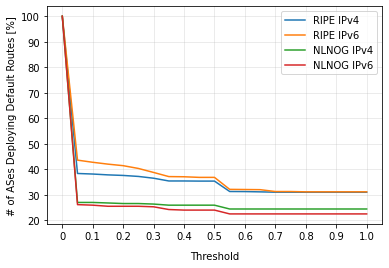

In [40]:
fig, ax = plt.subplots()
plt.plot(thresholds,ripe_v4_ratio, label='RIPE IPv4')
plt.plot(thresholds,ripe_v6_ratio, label='RIPE IPv6')
plt.plot(thresholds,nlnog_v4_ratio, label='NLNOG IPv4')
plt.plot(thresholds,nlnog_v6_ratio, label='NLNOG IPv6')
plt.xticks(thresholds, thresholds, rotation ='vertical')
plt.legend()
ax.set_ylabel('# of ASes Deploying Default Routes [%]')
ax.set_xlabel('Threshold', labelpad=10)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], False)
ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks(rotation = 0)
#ax.set_xticklabels('Threshold', labelpad=10)
plt.grid(which="major",alpha=0.3)
#ax.set_title('Impact of threshold on default route ratio')
plt.savefig('threshold.pdf', bbox_inches='tight')  
#plt.show()

In [21]:
for asn in results_hlavacek_day5_ripe_ipv4:
    print(results_hlavacek_day5_ripe_ipv4[asn])

[False, [33083, 21928], 31051152, 135, 2, 2]
[False, False, 31051152, 7, 0, 3]
[False, False, 31051152, 1, 0, 2]
[False, False, 31051152, 21, 0, 2]
[False, False, 31051152, 46, 0, 2]
[False, [6830, 12315, 13127], 31051152, 32, 3, 2]
[False, False, 31051152, 18, 0, 2]
[False, [9942], 31051152, 14, 1, 2]
[True, [2914], 31051152, 1, 1, 2]
[False, False, 31050973, 1, 0, 2]
[False, False, 31051152, 2, 0, 2]
[False, [3356], 31051152, 4, 1, 2]
[False, False, 31050973, 1, 0, 3]
[False, False, 31050973, 2, 0, 2]
[False, False, 31051152, 30, 0, 2]
[False, False, 31050973, 2, 0, 2]
[False, False, 31050973, 1, 0, 2]
[False, False, 31050973, 2, 0, 2]
[False, False, 31050973, 3, 0, 2]
[False, [6453], 31050973, 2, 1, 2]
[False, [48964], 31050973, 2, 1, 3]
[False, [4538, 4134], 31051152, 4, 2, 3]
[False, False, 31051152, 8, 0, 2]
[False, False, 31050973, 1, 0, 2]
[True, [35141], 31051152, 1, 1, 2]
[False, False, 31050973, 1, 0, 3]
[True, [60720], 31050973, 1, 1, 3]
[False, [39153], 31050973, 3, 1, 3]


In [22]:
#Show inconsistent results for AS3320:
print(results_hlavacek_day5_ripe_ipv4[3320])

[False, [7671], 31051152, 191, 1, 1]


In [23]:
#Overlap of NLNOG and RIPE Atlas probes:
print('#NLNOG VPs IPv4: ', len(results_hlavacek_day1_nlnog_ipv4.keys()))
print('#NLNOG VPs IPv6: ', len(results_hlavacek_day1_nlnog_ipv6.keys()))
print('Overlap IPv4 NLNOG & RIPE Atlas', len(results_hlavacek_day1_ripe_ipv4.keys() & results_hlavacek_day1_nlnog_ipv4.keys()))
print('Overlap IPv6 NLNOG & RIPE Atlas', len(results_hlavacek_day1_ripe_ipv6.keys() & results_hlavacek_day1_nlnog_ipv6.keys()))

print('Additional ASNs IPv4 added by NLNOG: ', len(results_hlavacek_day1_nlnog_ipv4.keys() - (results_hlavacek_day1_ripe_ipv4.keys() & results_hlavacek_day1_nlnog_ipv4.keys())))
print('Additional ASNs IPv6 added by NLNOG: ', len(results_hlavacek_day1_nlnog_ipv6.keys() - (results_hlavacek_day1_ripe_ipv6.keys() & results_hlavacek_day1_nlnog_ipv6.keys())))

#NLNOG VPs IPv4:  467
#NLNOG VPs IPv6:  467
Overlap IPv4 NLNOG & RIPE Atlas 272
Overlap IPv6 NLNOG & RIPE Atlas 228
Additional ASNs IPv4 added by NLNOG:  195
Additional ASNs IPv6 added by NLNOG:  239


In [24]:
#Are the results for NLNOG and RIPE Atlas the same?
overlap = results_hlavacek_day1_ripe_ipv4.keys() & results_hlavacek_day1_nlnog_ipv4.keys()
equal = 0
unequal = 0
for asn in overlap:
    if results_hlavacek_day1_ripe_ipv4[asn][0] == results_hlavacek_day1_nlnog_ipv4[asn][0]:
        equal += 1
    else:
        unequal += 1
        print(results_hlavacek_day1_ripe_ipv4[asn], results_hlavacek_day1_nlnog_ipv4[asn])
        
print()
print('Equal ASes: ', equal)
print('Unequal ASes: ', unequal)

[True, [3257], 30987575, 1, 1, 3] [False, False, 1624559859, 1, 0, 3]
[False, [3303], 30987663, 2, 1, 2] [True, [3303], 1624559859, 1, 1, 2]
[False, [201011], 30987663, 3, 1, 2] [True, [201011], 1624559859, 1, 1, 2]
[False, [12361], 30987575, 2, 1, 2] [True, [12361], 1624559859, 1, 1, 2]
[False, False, 30987663, 1, 0, 3] [True, [174], 1624559859, 1, 1, 3]
[False, [56300], 30987663, 2, 1, 3] [True, [56300], 1624559859, 1, 1, 3]
[False, [3213], 30987663, 2, 1, 3] [True, [3213], 1624559859, 1, 1, 3]
[False, False, 30987663, 1, 0, 2] [True, [8821], 1624559859, 1, 1, 2]
[True, [3356], 30987575, 1, 1, 2] [False, False, 1624559859, 3, 0, 2]
[False, [24961, 62240], 30987575, 4, 2, 2] [True, [1836], 1624559859, 1, 1, 2]
[False, [197288], 30987575, 2, 1, 2] [True, [197288], 1624559859, 1, 1, 2]
[True, [35280], 30987663, 1, 1, 2] [False, False, 1624559859, 1, 0, 2]
[False, False, 30987663, 1, 0, 2] [True, [1759], 1624559859, 1, 1, 2]
[True, [8717], 30987663, 1, 1, 2] [False, False, 1624559859, 1,

[3607, 3609, 3617, 3616, 3616]
[1657, 1658, 1666, 1671, 1664]
[467, 465, 466, 466, 465]
[467, 466, 465, 466, 466]
[1128, 1133, 1138, 1145, 1126]
[532, 528, 529, 527, 532]
[114, 112, 112, 113, 113]
[105, 104, 106, 106, 104]


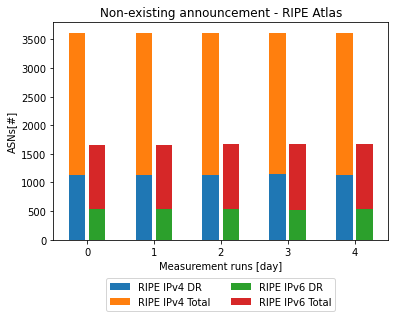

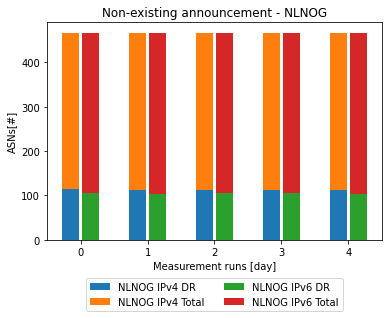

In [25]:
ripe_ipv4 = [get_ratio_data(results_hlavacek_day1_ripe_ipv4)[0],get_ratio_data(results_hlavacek_day2_ripe_ipv4)[0], get_ratio_data(results_hlavacek_day3_ripe_ipv4)[0], get_ratio_data(results_hlavacek_day4_ripe_ipv4)[0], get_ratio_data(results_hlavacek_day5_ripe_ipv4)[0]]
ripe_ipv6 = [get_ratio_data(results_hlavacek_day1_ripe_ipv6)[0],get_ratio_data(results_hlavacek_day2_ripe_ipv6)[0], get_ratio_data(results_hlavacek_day3_ripe_ipv6)[0], get_ratio_data(results_hlavacek_day4_ripe_ipv6)[0], get_ratio_data(results_hlavacek_day5_ripe_ipv6)[0]]
nlnog_ipv4 = [get_ratio_data(results_hlavacek_day1_nlnog_ipv4)[0],get_ratio_data(results_hlavacek_day2_nlnog_ipv4)[0], get_ratio_data(results_hlavacek_day3_nlnog_ipv4)[0], get_ratio_data(results_hlavacek_day4_nlnog_ipv4)[0], get_ratio_data(results_hlavacek_day5_nlnog_ipv4)[0]]
nlnog_ipv6 = [get_ratio_data(results_hlavacek_day1_nlnog_ipv6)[0],get_ratio_data(results_hlavacek_day2_nlnog_ipv6)[0], get_ratio_data(results_hlavacek_day3_nlnog_ipv6)[0], get_ratio_data(results_hlavacek_day4_nlnog_ipv6)[0], get_ratio_data(results_hlavacek_day5_nlnog_ipv6)[0]]

ripe_ipv4_dr = [get_ratio_data(results_hlavacek_day1_ripe_ipv4)[1],get_ratio_data(results_hlavacek_day2_ripe_ipv4)[1], get_ratio_data(results_hlavacek_day3_ripe_ipv4)[1], get_ratio_data(results_hlavacek_day4_ripe_ipv4)[1], get_ratio_data(results_hlavacek_day5_ripe_ipv4)[1]]
ripe_ipv6_dr = [get_ratio_data(results_hlavacek_day1_ripe_ipv6)[1],get_ratio_data(results_hlavacek_day2_ripe_ipv6)[1], get_ratio_data(results_hlavacek_day3_ripe_ipv6)[1], get_ratio_data(results_hlavacek_day4_ripe_ipv6)[1], get_ratio_data(results_hlavacek_day5_ripe_ipv6)[1]]
nlnog_ipv4_dr = [get_ratio_data(results_hlavacek_day1_nlnog_ipv4)[1],get_ratio_data(results_hlavacek_day2_nlnog_ipv4)[1], get_ratio_data(results_hlavacek_day3_nlnog_ipv4)[1], get_ratio_data(results_hlavacek_day4_nlnog_ipv4)[1], get_ratio_data(results_hlavacek_day5_nlnog_ipv4)[1]]
nlnog_ipv6_dr = [get_ratio_data(results_hlavacek_day1_nlnog_ipv6)[1],get_ratio_data(results_hlavacek_day2_nlnog_ipv6)[1], get_ratio_data(results_hlavacek_day3_nlnog_ipv6)[1], get_ratio_data(results_hlavacek_day4_nlnog_ipv6)[1], get_ratio_data(results_hlavacek_day5_nlnog_ipv6)[1]]


print(ripe_ipv4)
print(ripe_ipv6)
print(nlnog_ipv4)
print(nlnog_ipv6)

print(ripe_ipv4_dr)
print(ripe_ipv6_dr)
print(nlnog_ipv4_dr)
print(nlnog_ipv6_dr)



labels = [1, 2, 3, 4, 5]
width = 0.25       # the width of the bars: can also be len(x) sequence
space = 0.15

fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations

ax.bar(x - space, ripe_ipv4_dr, width, label='RIPE IPv4 DR')
ax.bar(x - space, np.subtract(ripe_ipv4, ripe_ipv4_dr), width, bottom=ripe_ipv4_dr, label='RIPE IPv4 Total')

ax.bar(x + space, ripe_ipv6, width, label='RIPE IPv6 DR')
ax.bar(x + space, np.subtract(ripe_ipv6, ripe_ipv6_dr), width, bottom=ripe_ipv6_dr, label='RIPE IPv6 Total')

ax.set_ylabel('ASNs[#]')
ax.set_xlabel('Measurement runs [day]')
ax.set_title('Non-existing announcement - RIPE Atlas')
#ax.legend(bbox_to_anchor=(1, 1))
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2)

plt.show()


fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations

ax.bar(x - space, nlnog_ipv4_dr, width, label='NLNOG IPv4 DR')
ax.bar(x - space, np.subtract(nlnog_ipv4, nlnog_ipv4_dr), width, bottom=nlnog_ipv4_dr, label='NLNOG IPv4 Total')

ax.bar(x + space, nlnog_ipv6, width, label='NLNOG IPv6 DR')
ax.bar(x + space, np.subtract(nlnog_ipv6, nlnog_ipv6_dr), width, bottom=nlnog_ipv6_dr, label='NLNOG IPv6 Total')

ax.set_ylabel('ASNs[#]')
ax.set_xlabel('Measurement runs [day]')
ax.set_title('Non-existing announcement - NLNOG')
#ax.legend(bbox_to_anchor=(1, 1))
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2)

plt.show()


In [28]:
#dr, upstream, timestamp, total, hit, tier

#Get Bush measurements:
cur.execute("SELECT COUNT(*) FROM bush_relaunch WHERE ip_version = 4")
for result in cur: print('IPv4 Bush results: ', result)   
    
cur.execute("SELECT COUNT(*) FROM bush_relaunch WHERE ip_version = 6")
for result in cur: print('IPv6 Bush results: ', result)
    
results_bush_ipv4 = {}
results_bush_ipv6 = {}

db_query = "SELECT * FROM bush_relaunch"
results_bush_ipv4, results_bush_ipv6 = fetch_from_db_bush(results_bush_ipv4, results_bush_ipv6, db_query) 

update_single_result_with_tiers(results_bush_ipv4, tier_classification) #Add tier information to dicts
update_single_result_with_tiers(results_bush_ipv6, tier_classification)

print('Bush, IPv4: ' + get_ratio_string(results_bush_ipv4))
print('Bush, IPv6: ' + get_ratio_string(results_bush_ipv6))

cur.execute("SELECT * FROM bush_relaunch WHERE ip_version != 6 AND ip_version != 4")
for result in cur: print('results: ', result)

#TODO: Check why results differ!


IPv4 Bush results:  (390,)
IPv6 Bush results:  (390,)


ValueError: invalid literal for int() with base 10: 'False'

In [ ]:
#create merged dicts (for day1): This will always favour RIPE Atlas and fill up with NLNOG results where Atlas is missing
results_hlavacek_day1_merged_ipv4 = merge_Atlas_NLNOG(results_hlavacek_day1_ripe_ipv4, results_hlavacek_day1_nlnog_ipv4)
results_hlavacek_day1_merged_ipv6 = merge_Atlas_NLNOG(results_hlavacek_day1_ripe_ipv6, results_hlavacek_day1_nlnog_ipv6)

In [ ]:
#What is the overlap in Bush and Hlavacek?
print('IPv4: ')
print('Overlap Bush & Hlavacek (Merged): ', len(results_bush_ipv4.keys() & results_hlavacek_day1_merged_ipv4.keys()))
print('Only Bush and not in Hlavacek (Merged): ', len(results_bush_ipv4.keys() - (results_bush_ipv4.keys() & results_hlavacek_day1_merged_ipv4.keys())))
print('Only Hlavacek (Merged) and not in Bush: ', len(results_hlavacek_day1_merged_ipv4.keys() - (results_bush_ipv4.keys() & results_hlavacek_day1_merged_ipv4.keys())))
print()
print('IPv6: ')
print('Overlap Bush & Hlavacek (Merged): ', len(results_bush_ipv6.keys() & results_hlavacek_day1_merged_ipv6.keys()))
print('Only Bush and not in Hlavacek (Merged): ', len(results_bush_ipv6.keys() - (results_bush_ipv6.keys() & results_hlavacek_day1_merged_ipv6.keys())))
print('Only Hlavacek (Merged) and not in Bush: ', len(results_hlavacek_day1_merged_ipv6.keys() - (results_bush_ipv6.keys() & results_hlavacek_day1_merged_ipv6.keys())))

In [ ]:
#Are Bush and Hlavacek results the same for the overlap?
overlap = results_hlavacek_day1_ripe_ipv4.keys() & results_bush_ipv4.keys()
equal = 0
unequal = 0
unequal_from_ripe = 0
unequal_from_icmp = 0
unequal_from_threshold = 0
for asn in overlap:
    if results_hlavacek_day1_ripe_ipv4[asn][0] == results_bush_ipv4[asn][0]:
        equal += 1
    else:
        unequal += 1
        #print(results_hlavacek_day1_ripe_ipv4[asn], results_bush_ipv4[asn])
        if results_hlavacek_day1_ripe_ipv4[asn][1] == False and results_bush_ipv4[asn][1] != False:
            #print(results_hlavacek_day1_ripe_ipv4[asn], results_bush_ipv4[asn])
            unequal_from_ripe += 1
            
        elif results_hlavacek_day1_ripe_ipv4[asn][0] == False and results_bush_ipv4[asn][1] == False:
            #print(results_hlavacek_day1_ripe_ipv4[asn], results_bush_ipv4[asn])
            unequal_from_icmp += 1
            
        elif results_hlavacek_day1_ripe_ipv4[asn][0] == False and results_bush_ipv4[asn][0] == True and results_hlavacek_day1_ripe_ipv4[asn][1] != False and results_bush_ipv4[asn][1] != False :
            unequal_from_threshold += 1
            
        elif results_hlavacek_day1_ripe_ipv4[asn][0] == True and results_bush_ipv4[asn][1] == False:
            #print(results_hlavacek_day1_ripe_ipv4[asn], results_bush_ipv4[asn])
            unequal_from_icmp += 1
            
        else:
            print(results_hlavacek_day1_ripe_ipv4[asn], results_bush_ipv4[asn])
            
            
            
print()
print('Equal ASes RIPE/Bush: ', equal)
print('Unequal ASes RIPE/Bush: ', unequal)
print('Unequal ASes from RIPE: ', unequal_from_ripe)
print('Unequal ASes from ICMP: ', unequal_from_icmp)
print('Unequal ASes from Threshold: ', unequal_from_threshold)

In [ ]:
#results_bush_ipv4

In [ ]:
results_bush_ipv4
results_bush_ipv6

bush_ipv4 = [get_ratio_data(results_bush_ipv4)[0]]
bush_ipv6 = [get_ratio_data(results_bush_ipv6)[0]]

bush_ipv4_dr = [get_ratio_data(results_bush_ipv4)[1]]
bush_ipv6_dr = [get_ratio_data(results_bush_ipv6)[1]]

print(bush_ipv4)
print(bush_ipv6)
print(bush_ipv4_dr)
print(bush_ipv6_dr)

labels = [0]
width = 0.6       # the width of the bars: can also be len(x) sequence
space = 0.4

fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
fig.set_size_inches(3, 5)

ax.bar(1 - space, bush_ipv4_dr, width, label='Bush IPv4 DR')
ax.bar(1 - space, np.subtract(bush_ipv4, bush_ipv4_dr), width, bottom=bush_ipv4_dr, label='Bush IPv4 Total')

ax.bar(1 + space, bush_ipv6, width, label='Bush IPv6 DR')
ax.bar(1 + space, np.subtract(bush_ipv6, bush_ipv6_dr), width, bottom=bush_ipv6_dr, label='Bush IPv6 Total')

ax.set_ylabel('ASNs[#]')
ax.set_xlabel('Results')
ax.set_title('Path-poisoning')
ax.legend(bbox_to_anchor=(1, 1))
plt.xticks([1], [])

plt.xlim([0, 2])

plt.show()


In [ ]:
#Check for AS Tier1 from CAIDA input clique:

input_clique = {174,209,286,701,1239,1299,2828,2914,3257,3320,3356,3491,5511,6453,6461,6762,6830,7018,12956} #require no transit to obtain global connectivity, from CAIDA

for asn in input_clique:
    print('Tier 1 AS: ', asn)
    if asn in results_hlavacek_day5_ripe_ipv4.keys():
        print(results_hlavacek_day5_ripe_ipv4[asn])
        #if results_hlavacek_day5_ripe_ipv4[asn][0] == True:
        #    print(results_hlavacek_day5_ripe_ipv4[asn][3])
    print()
        
#results_hlavacek_day5_ripe_ipv4[174]

In [ ]:
#Create figure for default routes and AS customer cone
as_rank = {}

#read asns.json file with customer cone size information
with open('data/asns.jsonl') as f:
    as_rank_file = list(f)

for line in as_rank_file:
    entry = json.loads(line)
    #print(entry)
    as_rank[int(entry['asn'])] = [int(entry['cone']['numberAsns']),int(entry['cone']['numberPrefixes'])]
    #print(entry['asn'], entry['cone']['numberAsns'], entry['cone']['numberPrefixes'])

In [ ]:
print(len(as_rank))
results_hlavacek_day1_ripe_ipv4
#as_rank[680]
#as_rank[3320]

In [ ]:
data_v4 = {}
for asn in results_hlavacek_day1_ripe_ipv4.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv4[asn][0]:
            data_v4[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v4[asn] = [0, as_rank[asn][0]]

data_v6 = {}
for asn in results_hlavacek_day1_ripe_ipv6.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv6[asn][0]:
            data_v6[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v6[asn] = [0, as_rank[asn][0]]
            
default_v4 = []
non_default_v4 = []      
default_v6 = []
non_default_v6 = []

for v in data_v4.values():
    if v[0]:
        default_v4.append(v[1])
    else:
        non_default_v4.append(v[1])

for v in data_v6.values():
    if v[0]:
        default_v6.append(v[1])
    else:
        non_default_v6.append(v[1])
        
yy1, x1 = np.histogram(default_v4, bins=50000)
yy2, x2 = np.histogram(non_default_v4, bins=50000)
yy3, x3 = np.histogram(default_v6, bins=50000)
yy4, x4 = np.histogram(non_default_v6, bins=50000)

y1 = np.cumsum(yy1) / (np.sum(yy1)+np.sum(yy2))
y2 = np.cumsum(yy2) / (np.sum(yy1)+np.sum(yy2))
y3 = np.cumsum(yy3) / (np.sum(yy3)+np.sum(yy4))
y4 = np.cumsum(yy4) / (np.sum(yy3)+np.sum(yy4))

plt.plot(x1[1:], y1, label="IPv4 default", color='black', alpha=0.7)
plt.plot(x2[1:], y2, label="IPv4 non-default", color='black', linestyle='dashed', alpha=0.7)
plt.plot(x3[1:], y3, label="IPv6 default", color='green', alpha=0.7)
plt.plot(x4[1:], y4, label="IPv6 non-default", color='green', linestyle='dashed', alpha=0.7)
plt.xlim([0, 200])
#plt.ylim([0.4, 1])
plt.xlabel("Customer cone size [# ASes]")
plt.ylabel("Cumulative fraction of ASes")
plt.legend()
plt.grid(which="major",alpha=0.3)
plt.savefig('cdf.pdf', bbox_inches='tight') 

In [ ]:
data_v4 = {}
for asn in results_hlavacek_day1_ripe_ipv4.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv4[asn][0]:
            data_v4[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v4[asn] = [0, as_rank[asn][0]]

data_v6 = {}
for asn in results_hlavacek_day1_ripe_ipv6.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv6[asn][0]:
            data_v6[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v6[asn] = [0, as_rank[asn][0]]
            
default_v4 = []
non_default_v4 = []      
default_v6 = []
non_default_v6 = []

for v in data_v4.values():
    if v[0]:
        default_v4.append(v[1])
    else:
        non_default_v4.append(v[1])

for v in data_v6.values():
    if v[0]:
        default_v6.append(v[1])
    else:
        non_default_v6.append(v[1])
        
N = 150
yy1 = np.bincount(default_v4)#[:N]
yy2 = np.bincount(non_default_v4)#[:N]
yy3 = np.bincount(default_v6)#[:N]
yy4 = np.bincount(non_default_v6)#[:N]

y1 = (100. * np.cumsum(yy1)) / np.sum(yy1)
y2 = (100. * np.cumsum(yy2)) / np.sum(yy2)
y3 = (100. * np.cumsum(yy3)) / np.sum(yy3)
y4 = (100. * np.cumsum(yy4)) / np.sum(yy4)

x = np.arange(1, len(y1)+1)

plt.plot(np.arange(1, len(y1)+1), y1, label="IPv4 default", color='black', alpha=0.7)
plt.plot(np.arange(1, len(y2)+1), y2, label="IPv4 non-default", color='black', linestyle='dashed', alpha=0.7)
plt.plot(np.arange(1, len(y3)+1), y3, label="IPv6 default", color='green', alpha=0.7)
plt.plot(np.arange(1, len(y4)+1), y4, label="IPv6 non-default", color='green', linestyle='dashed', alpha=0.7)
plt.xlim([0, 100])
#plt.ylim([0.4, 1])
plt.xlabel("Customer cone size [# ASes]")
plt.ylabel("Cumulative fraction of ASes")
plt.legend()
plt.grid()
#plt.grid(which="major",alpha=0.3)
plt.savefig('cdf.pdf', bbox_inches='tight') 

In [ ]:
data_v4 = {}
for asn in results_hlavacek_day1_ripe_ipv4.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv4[asn][0]:
            data_v4[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v4[asn] = [0, as_rank[asn][0]]

data_v6 = {}
for asn in results_hlavacek_day1_ripe_ipv6.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv6[asn][0]:
            data_v6[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v6[asn] = [0, as_rank[asn][0]]
            
default_v4 = []
non_default_v4 = []      
default_v6 = []
non_default_v6 = []

for v in data_v4.values():
    if v[0]:
        default_v4.append(v[1])
    else:
        non_default_v4.append(v[1])

for v in data_v6.values():
    if v[0]:
        default_v6.append(v[1])
    else:
        non_default_v6.append(v[1])
        


yy1 = np.bincount(default_v4)[:150]
yy2 = np.bincount(non_default_v4)[:150]
yy3 = np.bincount(default_v6)[:150]
yy4 = np.bincount(non_default_v6)[:150]

#for i, (v1,v2,v3,v4) in enumerate(zip(yy1, yy2, yy3, yy4)):
#    print(i, v1, v2, v3, v4)


y1 = (100. * np.cumsum(yy1)) / (np.cumsum(yy1) + np.cumsum(yy2))
y2 = (100. * np.cumsum(yy2)) / (np.cumsum(yy1) + np.cumsum(yy2))
y3 = (100. * np.cumsum(yy3)) / (np.cumsum(yy3) + np.cumsum(yy4))
y4 = (100. * np.cumsum(yy4)) / (np.cumsum(yy3) + np.cumsum(yy4))

x = np.arange(1, len(y1)+1)



plt.plot(x, y1, label="IPv4 default", color='black', alpha=0.7)
plt.plot(x, y2, label="IPv4 non-default", color='black', linestyle='dashed', alpha=0.7)
plt.plot(x, y3, label="IPv6 default", color='green', alpha=0.7)
plt.plot(x, y4, label="IPv6 non-default", color='green', linestyle='dashed', alpha=0.7)
plt.xlim([0, 50])
#plt.ylim([0.4, 1])
plt.xlabel("Customer cone size [# ASes]")
plt.ylabel("Fraction of ASes [%]")
plt.legend()
plt.grid()
# plt.grid(which="major",alpha=0.3)
plt.savefig('fraction.pdf', bbox_inches='tight') 

In [ ]:
data_v4 = {}
for asn in results_hlavacek_day1_ripe_ipv4.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv4[asn][0]:
            data_v4[asn] = [1, as_rank[asn][1]] #numberPrefixes
        else:
            data_v4[asn] = [0, as_rank[asn][1]]

data_v6 = {}
for asn in results_hlavacek_day1_ripe_ipv6.keys():
    if asn in as_rank.keys(): #some asns are not present
        if results_hlavacek_day1_ripe_ipv6[asn][0]:
            data_v6[asn] = [1, as_rank[asn][0]] #numberAsns
        else:
            data_v6[asn] = [0, as_rank[asn][0]]
            
default_v4 = []
non_default_v4 = []      
default_v6 = []
non_default_v6 = []

for v in data_v4.values():
    if v[0]:
        default_v4.append(v[1])
    else:
        non_default_v4.append(v[1])

for v in data_v6.values():
    if v[0]:
        default_v6.append(v[1])
    else:
        non_default_v6.append(v[1])
        
yy1, x1 = np.histogram(default_v4, bins=50000)
yy2, x2 = np.histogram(non_default_v4, bins=50000)
yy3, x3 = np.histogram(default_v6, bins=50000)
yy4, x4 = np.histogram(non_default_v6, bins=50000)

y1 = np.cumsum(yy1) / np.sum(yy1)
y2 = np.cumsum(yy2) / np.sum(yy2)
y3 = np.cumsum(yy3) / np.sum(yy3)
y4 = np.cumsum(yy4) / np.sum(yy4)

plt.plot(x1[1:], y1, label="IPv4 default", color='black', alpha=0.7)
plt.plot(x2[1:], y2, label="IPv4 non-default", color='black', linestyle='dashed', alpha=0.7)
plt.plot(x3[1:], y3, label="IPv6 default", color='green', alpha=0.7)
plt.plot(x4[1:], y4, label="IPv6 non-default", color='green', linestyle='dashed', alpha=0.7)
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.xlabel("Customer cone size [# Prefixes]")
plt.ylabel("Cumulative fraction of ASes")
plt.legend()
plt.grid()